# Neural Prediction Analysis
## Electrophysiological Data Analysis from Multi-Electrode Array Recordings

This notebook analyzes neural spike data from soma recordings.

## 1. Setup and Load Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path

# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

with open('configDataset.yaml', 'r') as f:
    configDataset = yaml.safe_load(f)

config['data']['dataset_path'] = configDataset['data']['dataset_path']

# Set plotting style
plt.style.use(config['plotting']['style'])
sns.set_palette('husl')

print("Configuration loaded successfully!")
print(f"Dataset path: {config['data']['dataset_path']}")

Configuration loaded successfully!
Dataset path: data/sample_dataset_somata.csv


## 2. Load Data

In [2]:
# Load the dataset
data_path = config['data']['dataset_path']
df = pd.read_csv(data_path, sep='\t')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset loaded: 98985 rows, 7 columns

Column names: ['time', 'channel', 'amplitude', 'electrode', 'x', 'y', 'experiment']

First few rows:


,time,channel,amplitude,electrode,x,y,experiment
0,0.00005,138.0,-73.772410,25083.0,52.5,1995.0,19312_Jan28_2024__30
1,0.00100,683.0,-13.252719,24368.0,2940.0,1925.0,21645_Jan28_2024__18
2,0.00315,616.0,-4.428850,7519.0,682.5,595.0,21645_Jan28_2024__18
3,0.01330,138.0,-74.319305,25083.0,52.5,1995.0,19312_Jan28_2024__30
4,0.01690,776.0,-13.129807,6877.0,997.5,542.5,19312_Jan28_2024__30


## 3. Data Overview and Summary Statistics

In [3]:
# Basic statistics
print("=" * 60)
print("DATASET SUMMARY")
print("=" * 60)

print(f"\nTime range: {df['time'].min():.6f} to {df['time'].max():.6f} seconds")
print(f"Duration: {df['time'].max() - df['time'].min():.2f} seconds")

print(f"\nNumber of unique experiments: {df['experiment'].nunique()}")
print(f"Experiments: {df['experiment'].unique()}")

print(f"\nNumber of unique channels: {df['channel'].nunique()}")
print(f"Channels: {sorted(df['channel'].unique())}")

print(f"\nNumber of unique electrodes: {df['electrode'].nunique()}")

print(f"\nAmplitude statistics:")
print(df['amplitude'].describe())

print(f"\nSpatial range:")
print(f"  X: {df['x'].min()} to {df['x'].max()}")
print(f"  Y: {df['y'].min()} to {df['y'].max()}")

DATASET SUMMARY

Time range: 0.000050 to 8383.252400 seconds
Duration: 8383.25 seconds

Number of unique experiments: 2
Experiments: ['19312_Jan28_2024__30' '21645_Jan28_2024__18']

Number of unique channels: 4
Channels: [np.float64(138.0), np.float64(616.0), np.float64(683.0), np.float64(776.0)]

Number of unique electrodes: 4

Amplitude statistics:
count    98985.000000
mean       -31.662231
std         51.828104
min       -328.873780
25%        -13.829641
50%         -9.508604
75%         -7.577878
max         -3.230537
Name: amplitude, dtype: float64

Spatial range:
  X: 52.5 to 2940.0
  Y: 542.5 to 1995.0


In [4]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Data types
print("\nData types:")
print(df.dtypes)


Missing values per column:
time          0
channel       0
amplitude     0
electrode     0
x             0
y             0
experiment    0
dtype: int64

Data types:
time          float64
channel       float64
amplitude     float64
electrode     float64
x             float64
y             float64
experiment     object
dtype: object


## 4. Channel-wise Analysis

Recordings per channel:
channel
138.0    17950
616.0    60562
683.0     7927
776.0    12546
Name: count, dtype: int64


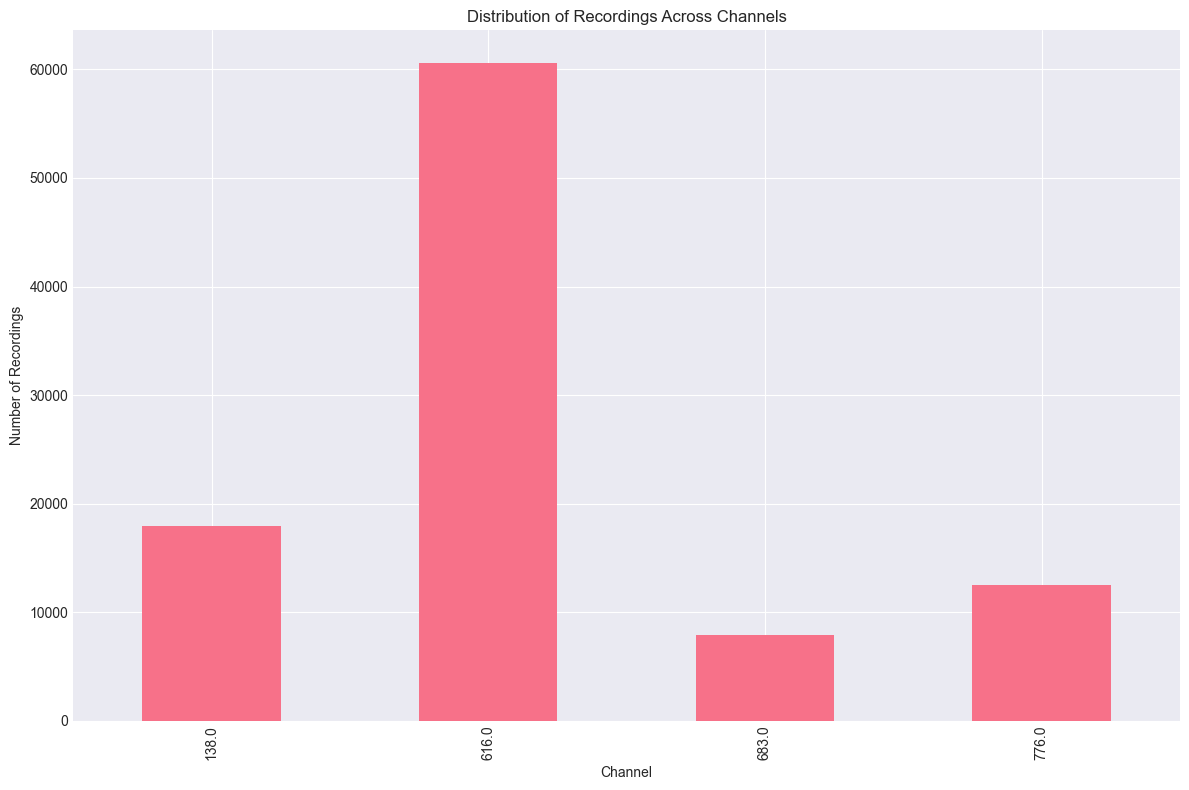

In [5]:
# Number of recordings per channel
channel_counts = df['channel'].value_counts().sort_index()

print("Recordings per channel:")
print(channel_counts)

# Plot
fig, ax = plt.subplots(figsize=tuple(config['plotting']['figure_size']))
channel_counts.plot(kind='bar', ax=ax)
ax.set_xlabel('Channel')
ax.set_ylabel('Number of Recordings')
ax.set_title('Distribution of Recordings Across Channels')
plt.tight_layout()
plt.show()

In [6]:
# Amplitude statistics per channel
print("\nAmplitude statistics per channel:")
channel_stats = df.groupby('channel')['amplitude'].agg(['mean', 'std', 'min', 'max', 'count'])
print(channel_stats)


Amplitude statistics per channel:
              mean        std         min       max  count
channel                                                   
138.0   -90.923089  54.342032 -328.873780 -7.834129  17950
616.0    -8.922999   3.275118  -37.065666 -3.595246  60562
683.0    -7.628222   3.643454  -22.477960 -3.230537   7927
776.0   -71.827907  86.079802 -280.587000 -7.235188  12546


## 5. Spike Detection Analysis

In [7]:
# Detect spikes based on threshold
spike_threshold = config['analysis']['spike_threshold']
df['is_spike'] = np.abs(df['amplitude']) > spike_threshold

print(f"Spike detection threshold: {spike_threshold}")
print(f"Total spikes detected: {df['is_spike'].sum()}")
print(f"Percentage of recordings with spikes: {100 * df['is_spike'].sum() / len(df):.2f}%")

# Spikes per channel
spikes_per_channel = df[df['is_spike']].groupby('channel').size()
print(f"\nSpikes per channel:")
print(spikes_per_channel)

Spike detection threshold: 50.0
Total spikes detected: 21175
Percentage of recordings with spikes: 21.39%

Spikes per channel:
channel
138.0    16791
776.0     4384
dtype: int64


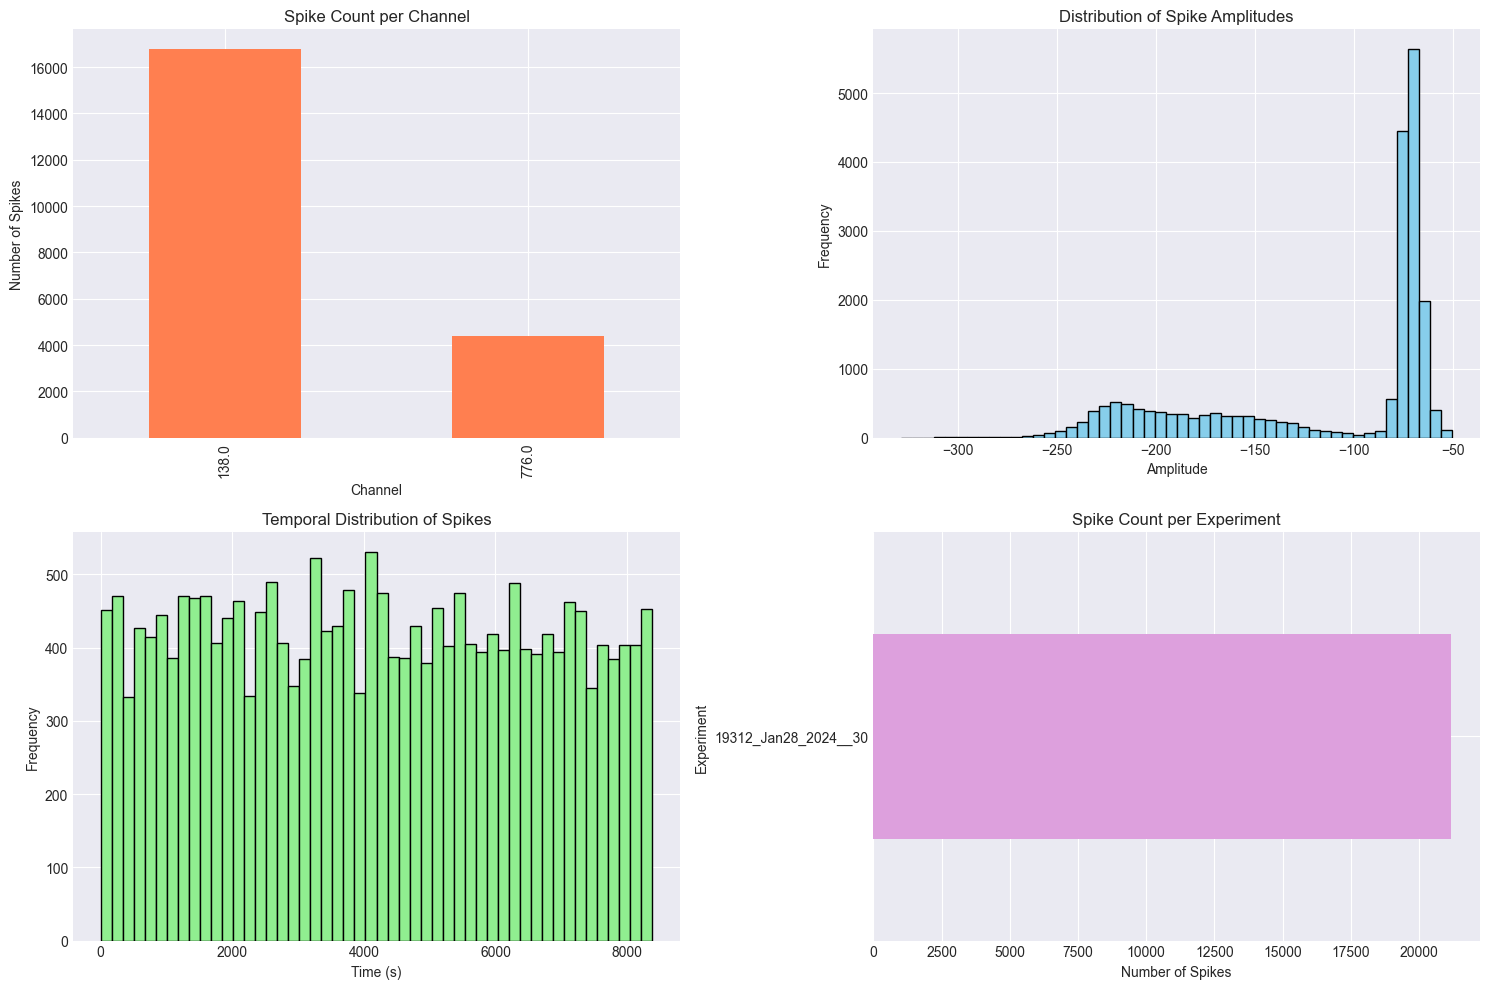

In [8]:
# Plot spike distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Spikes per channel
spikes_per_channel.plot(kind='bar', ax=axes[0, 0], color='coral')
axes[0, 0].set_xlabel('Channel')
axes[0, 0].set_ylabel('Number of Spikes')
axes[0, 0].set_title('Spike Count per Channel')

# 2. Spike amplitude distribution
spike_amplitudes = df[df['is_spike']]['amplitude']
axes[0, 1].hist(spike_amplitudes, bins=50, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Amplitude')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Spike Amplitudes')

# 3. Spike times histogram
spike_times = df[df['is_spike']]['time']
axes[1, 0].hist(spike_times, bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Temporal Distribution of Spikes')

# 4. Spikes per experiment
spikes_per_exp = df[df['is_spike']].groupby('experiment').size()
spikes_per_exp.plot(kind='barh', ax=axes[1, 1], color='plum')
axes[1, 1].set_xlabel('Number of Spikes')
axes[1, 1].set_ylabel('Experiment')
axes[1, 1].set_title('Spike Count per Experiment')

plt.tight_layout()
plt.show()

## 6. Temporal Analysis

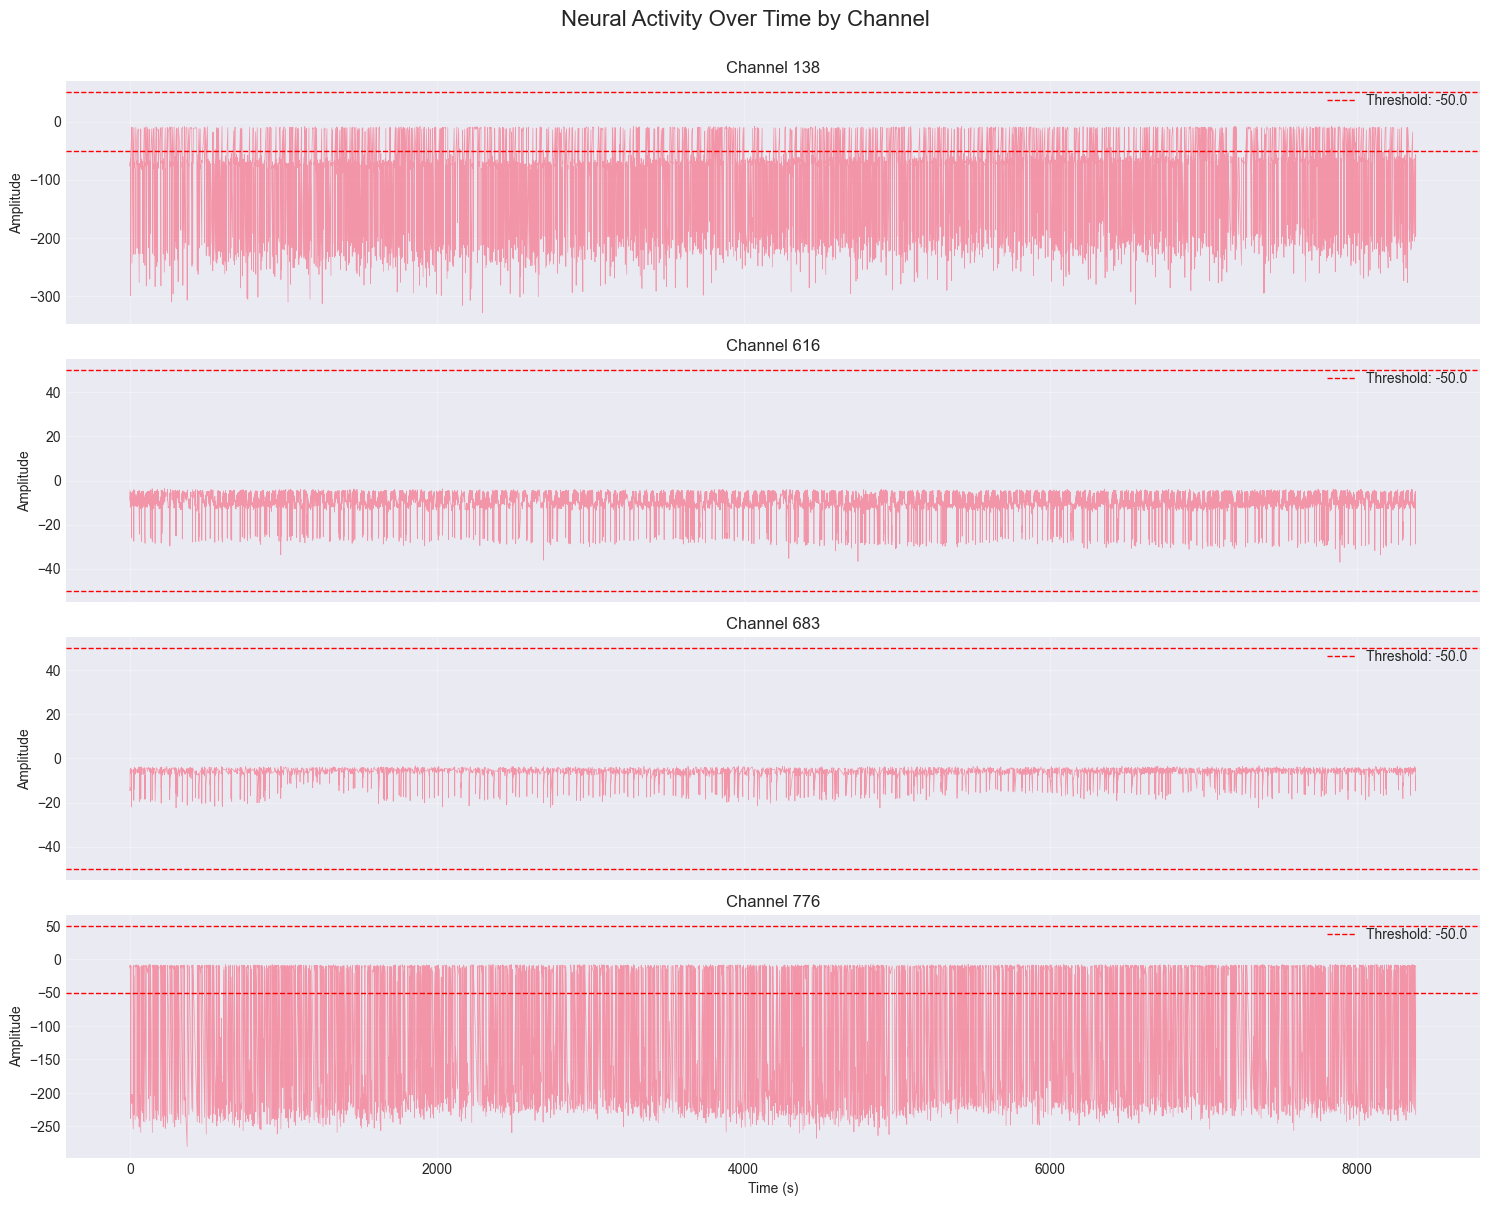

In [9]:
# Plot amplitude over time for each channel
fig, axes = plt.subplots(len(df['channel'].unique()), 1, 
                         figsize=(15, 3 * len(df['channel'].unique())), 
                         sharex=True)

if len(df['channel'].unique()) == 1:
    axes = [axes]

for idx, channel in enumerate(sorted(df['channel'].unique())):
    channel_data = df[df['channel'] == channel]
    axes[idx].plot(channel_data['time'], channel_data['amplitude'], 
                   linewidth=0.5, alpha=0.7)
    axes[idx].axhline(y=-spike_threshold, color='r', linestyle='--', 
                      linewidth=1, label=f'Threshold: -{spike_threshold}')
    axes[idx].axhline(y=spike_threshold, color='r', linestyle='--', linewidth=1)
    axes[idx].set_ylabel('Amplitude')
    axes[idx].set_title(f'Channel {int(channel)}')
    axes[idx].legend(loc='upper right')
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')
plt.suptitle('Neural Activity Over Time by Channel', y=1.001, fontsize=16)
plt.tight_layout()
plt.show()

## 7. Spatial Analysis

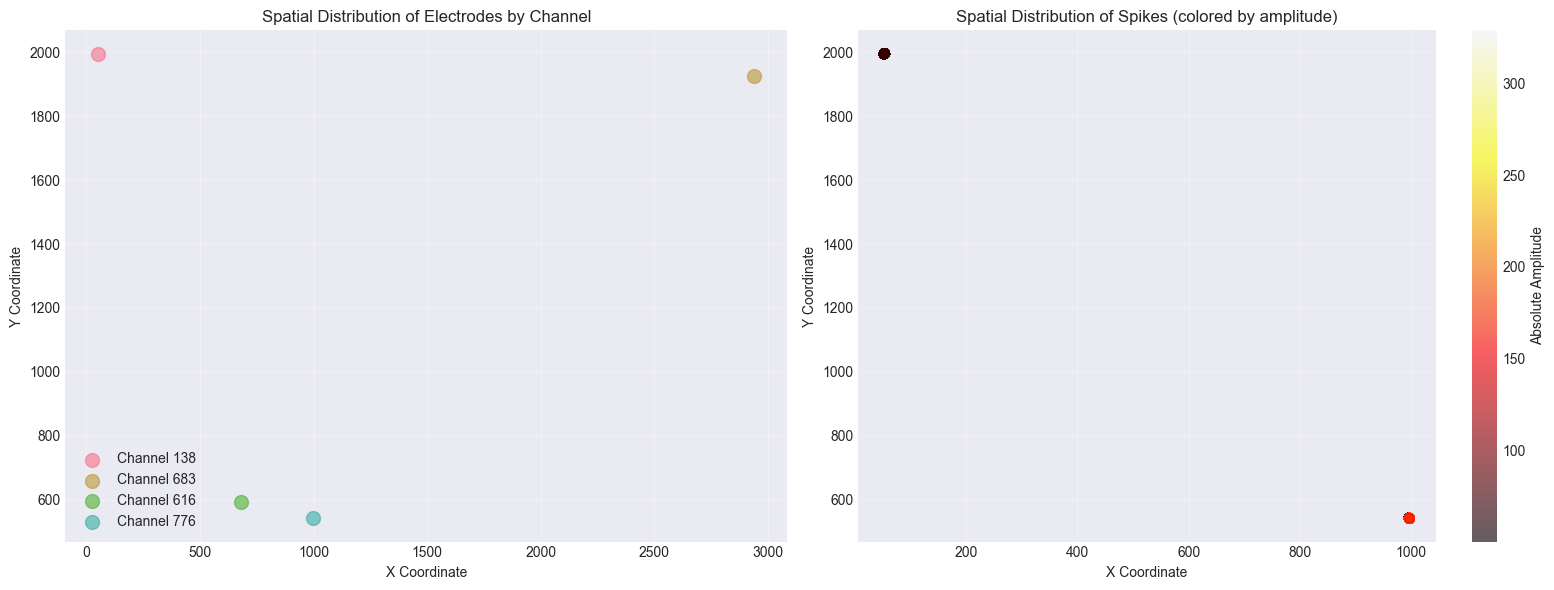

In [10]:
# Spatial distribution of electrodes
electrode_locations = df.groupby('electrode')[['x', 'y']].first()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. All electrode locations
for channel in df['channel'].unique():
    channel_electrodes = df[df['channel'] == channel][['x', 'y', 'electrode']].drop_duplicates()
    axes[0].scatter(channel_electrodes['x'], channel_electrodes['y'], 
                   s=100, alpha=0.6, label=f'Channel {int(channel)}')

axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
axes[0].set_title('Spatial Distribution of Electrodes by Channel')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Spike locations (heatmap)
spike_data = df[df['is_spike']]
if len(spike_data) > 0:
    scatter = axes[1].scatter(spike_data['x'], spike_data['y'], 
                             c=np.abs(spike_data['amplitude']), 
                             s=50, alpha=0.6, cmap='hot')
    axes[1].set_xlabel('X Coordinate')
    axes[1].set_ylabel('Y Coordinate')
    axes[1].set_title('Spatial Distribution of Spikes (colored by amplitude)')
    plt.colorbar(scatter, ax=axes[1], label='Absolute Amplitude')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Inter-Spike Interval (ISI) Analysis

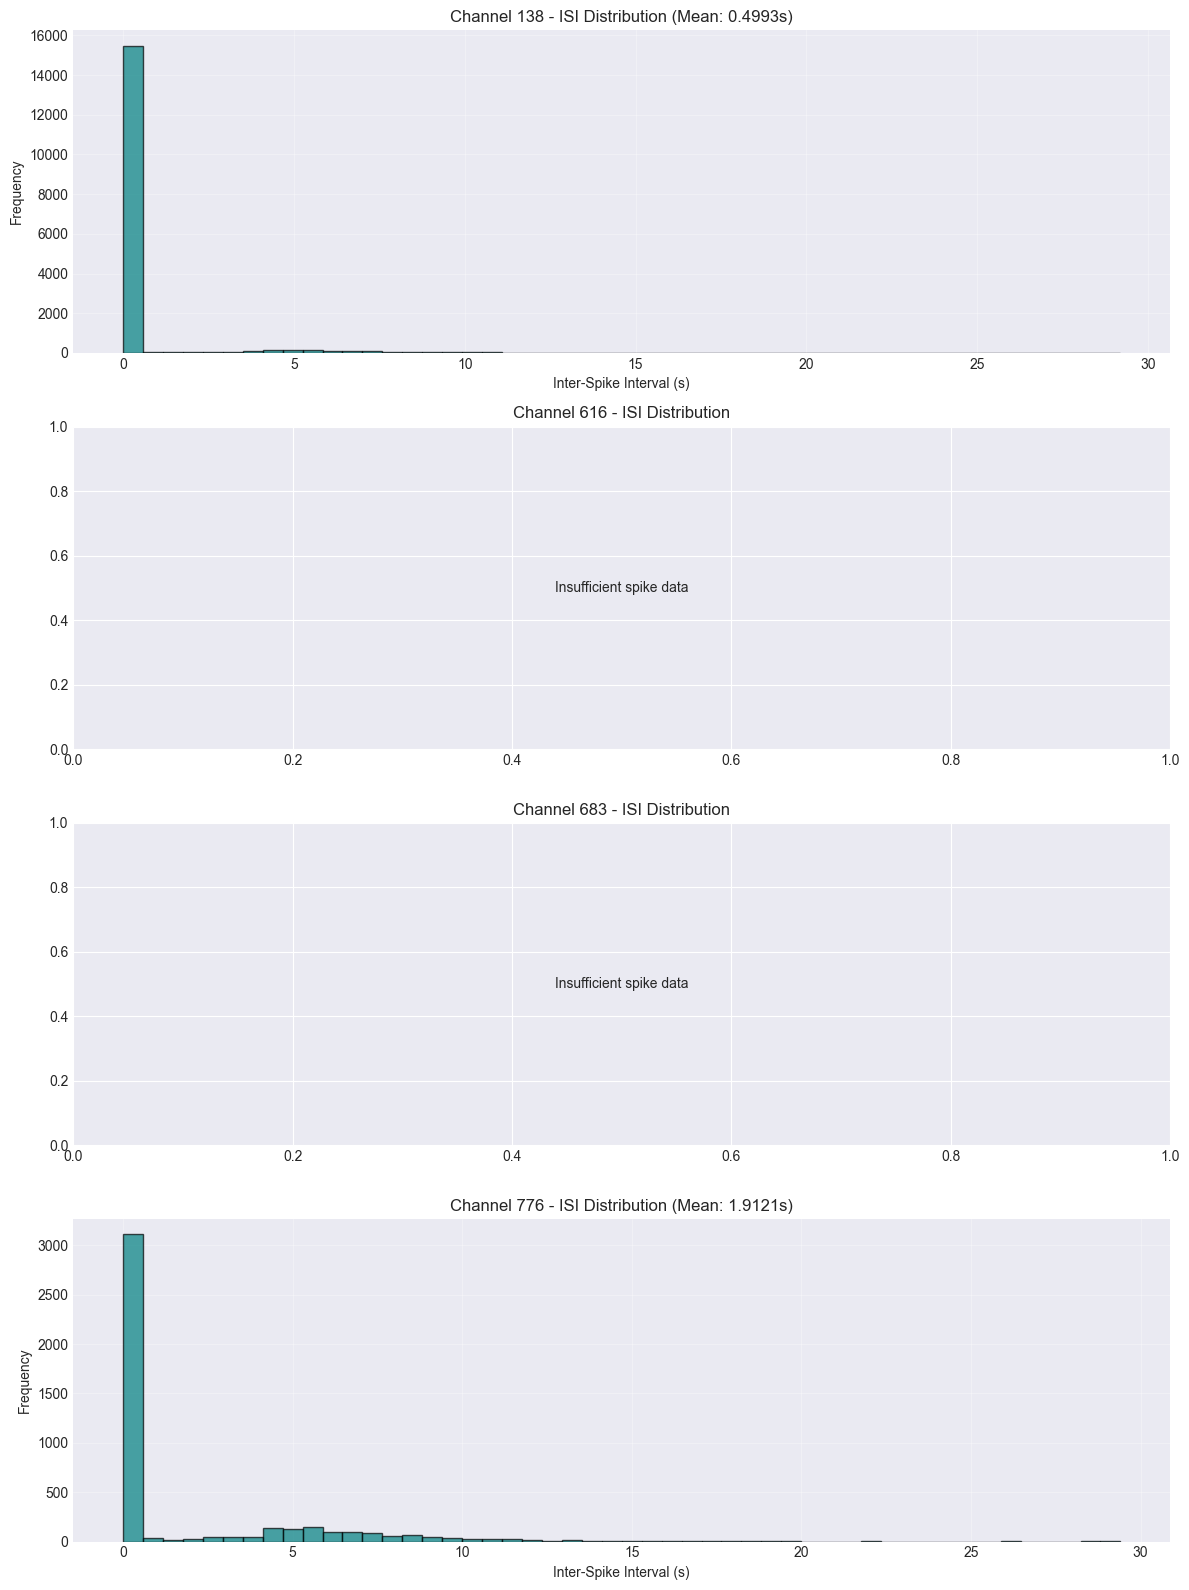

In [11]:
# Calculate ISI for each channel
fig, axes = plt.subplots(len(df['channel'].unique()), 1, 
                         figsize=(12, 4 * len(df['channel'].unique())))

if len(df['channel'].unique()) == 1:
    axes = [axes]

for idx, channel in enumerate(sorted(df['channel'].unique())):
    channel_spikes = df[(df['channel'] == channel) & (df['is_spike'])]['time'].values
    
    if len(channel_spikes) > 1:
        isi = np.diff(channel_spikes)
        
        axes[idx].hist(isi, bins=50, color='teal', edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel('Inter-Spike Interval (s)')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Channel {int(channel)} - ISI Distribution (Mean: {np.mean(isi):.4f}s)')
        axes[idx].grid(True, alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, 'Insufficient spike data', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'Channel {int(channel)} - ISI Distribution')

plt.tight_layout()
plt.show()

## 9. Experiment Comparison

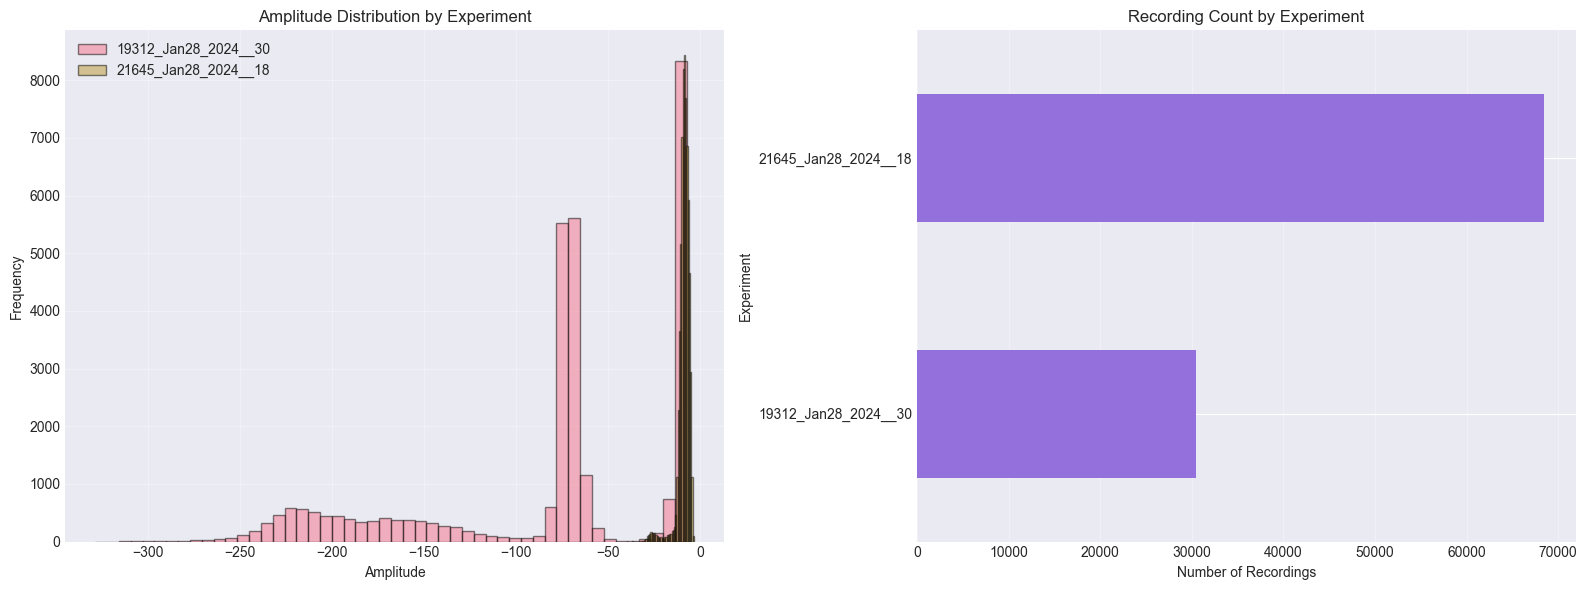

In [12]:
# Compare experiments
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Amplitude distribution by experiment
for exp in df['experiment'].unique():
    exp_data = df[df['experiment'] == exp]['amplitude']
    axes[0].hist(exp_data, bins=50, alpha=0.5, label=exp, edgecolor='black')

axes[0].set_xlabel('Amplitude')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Amplitude Distribution by Experiment')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Recording counts by experiment
exp_counts = df.groupby('experiment').size()
exp_counts.plot(kind='barh', ax=axes[1], color='mediumpurple')
axes[1].set_xlabel('Number of Recordings')
axes[1].set_ylabel('Experiment')
axes[1].set_title('Recording Count by Experiment')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 10. Correlation Analysis

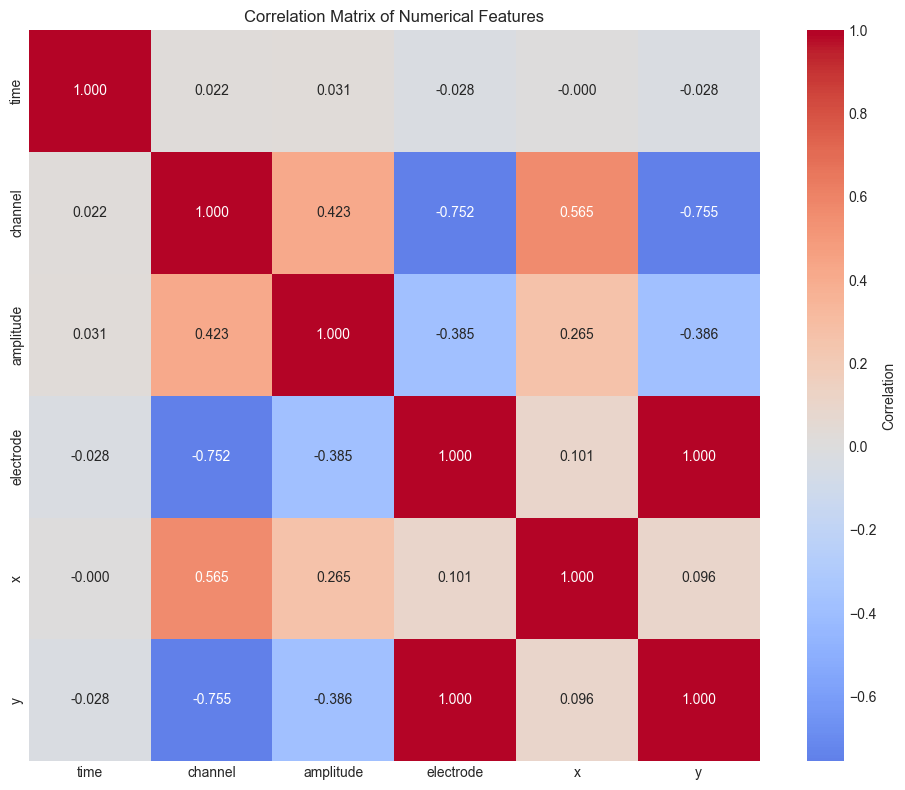

In [13]:
# Correlation matrix of numerical features
numerical_cols = ['time', 'channel', 'amplitude', 'electrode', 'x', 'y']
corr_matrix = df[numerical_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

## 11. Summary Report

In [14]:
print("="*70)
print("NEURAL PREDICTION ANALYSIS - SUMMARY REPORT")
print("="*70)

print(f"\n📊 Dataset: {config['data']['dataset_path']}")
print(f"   Total recordings: {len(df):,}")
print(f"   Time span: {df['time'].max() - df['time'].min():.2f} seconds")

print(f"\n🧪 Experiments: {df['experiment'].nunique()}")
for exp in df['experiment'].unique():
    count = len(df[df['experiment'] == exp])
    print(f"   - {exp}: {count:,} recordings")

print(f"\n📡 Channels: {df['channel'].nunique()}")
for channel in sorted(df['channel'].unique()):
    count = len(df[df['channel'] == channel])
    spikes = df[(df['channel'] == channel) & (df['is_spike'])].shape[0]
    print(f"   - Channel {int(channel)}: {count:,} recordings, {spikes} spikes")

print(f"\n⚡ Spike Analysis:")
print(f"   Threshold: ±{spike_threshold}")
print(f"   Total spikes: {df['is_spike'].sum():,}")
print(f"   Spike rate: {df['is_spike'].sum() / (df['time'].max() - df['time'].min()):.2f} spikes/second")

print(f"\n📈 Amplitude Statistics:")
print(f"   Mean: {df['amplitude'].mean():.3f}")
print(f"   Std: {df['amplitude'].std():.3f}")
print(f"   Min: {df['amplitude'].min():.3f}")
print(f"   Max: {df['amplitude'].max():.3f}")

print(f"\n🗺️ Spatial Coverage:")
print(f"   X range: {df['x'].min()} - {df['x'].max()}")
print(f"   Y range: {df['y'].min()} - {df['y'].max()}")
print(f"   Unique electrodes: {df['electrode'].nunique()}")

print("\n" + "="*70)

NEURAL PREDICTION ANALYSIS - SUMMARY REPORT

📊 Dataset: data/sample_dataset_somata.csv
   Total recordings: 98,985
   Time span: 8383.25 seconds

🧪 Experiments: 2
   - 19312_Jan28_2024__30: 30,496 recordings
   - 21645_Jan28_2024__18: 68,489 recordings

📡 Channels: 4
   - Channel 138: 17,950 recordings, 16791 spikes
   - Channel 616: 60,562 recordings, 0 spikes
   - Channel 683: 7,927 recordings, 0 spikes
   - Channel 776: 12,546 recordings, 4384 spikes

⚡ Spike Analysis:
   Threshold: ±50.0
   Total spikes: 21,175
   Spike rate: 2.53 spikes/second

📈 Amplitude Statistics:
   Mean: -31.662
   Std: 51.828
   Min: -328.874
   Max: -3.231

🗺️ Spatial Coverage:
   X range: 52.5 - 2940.0
   Y range: 542.5 - 1995.0
   Unique electrodes: 4

